In [1]:
import fedhex as fx
from matplotlib import pyplot as plt
import numpy as np

2023-08-27 15:44:53.840746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_path = "./root/10x10box_10k_jun2023/"
rl = fx.RootLoader(path=root_path)

In [3]:
thresh = 150
samples, labels = rl.load(event_thresh=thresh)

15:44:56.07 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


In [4]:
data, cond = rl.preproc()

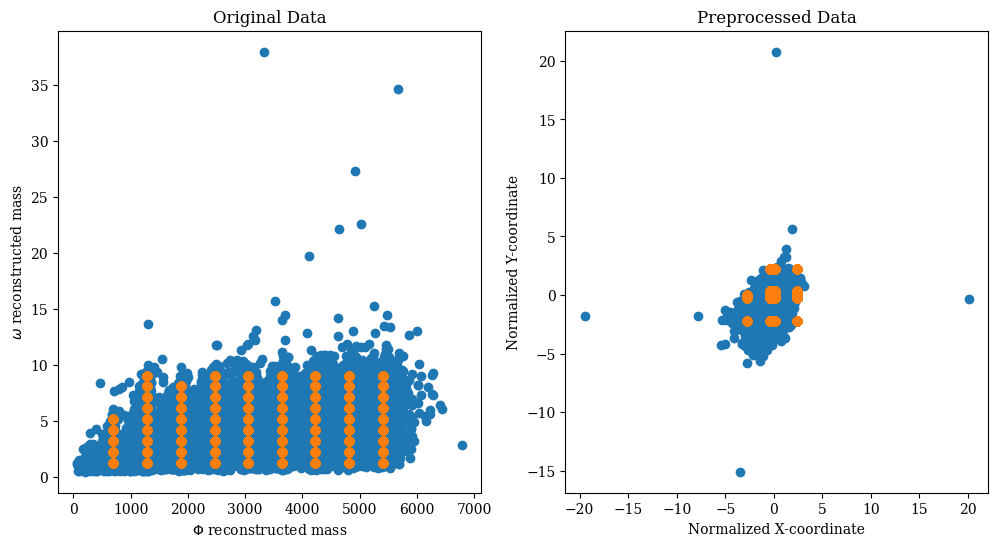

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(samples[:,0], samples[:,1])
ax1.scatter(labels[:,0], labels[:,1])
ax1.set_title("Original Data")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(data[:,0], data[:,1])
ax2.scatter(cond[:,0], cond[:,1])
ax2.set_title("Preprocessed Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

In [6]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

In [7]:
mm.compile_model()

In [8]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/08-24_tut_root/"
loss_path = flow_path + "loss.npy"

In [9]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [10]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

15:45:11.94 <I> [Training begins]
epoch begin: 2023-08-27 15:45:25.568171 | time elapsed: 0:00:13.553662
Epoch 10/200
47/47 [==============================] - 1s 17ms/sample - loss: 3.7476
epoch begin: 2023-08-27 15:45:32.622449 | time elapsed: 0:00:20.607940
Epoch 20/200
47/47 [==============================] - 1s 15ms/sample - loss: 2.3306
epoch begin: 2023-08-27 15:45:39.612239 | time elapsed: 0:00:27.597730
Epoch 30/200
47/47 [==============================] - 1s 15ms/sample - loss: 1.8410
epoch begin: 2023-08-27 15:45:46.708947 | time elapsed: 0:00:34.694438
Epoch 40/200
47/47 [==============================] - 1s 15ms/sample - loss: 1.4357
epoch begin: 2023-08-27 15:45:53.825887 | time elapsed: 0:00:41.811378
Epoch 50/200
47/47 [==============================] - 1s 15ms/sample - loss: 0.8800
epoch begin: 2023-08-27 15:46:00.962784 | time elapsed: 0:00:48.948275
Epoch 60/200
47/47 [==============================] - 1s 15ms/sample - loss: 0.4328
epoch begin: 2023-08-27 15:46:08.090

INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


15:48:06.29 <I> [Training ends]
0:02:54.35 <I> [Time elapsed]


In [11]:
ngen = 500
gen_labels_unique = [2464., 5.125]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = rl.norm(gen_labels, is_cond=True)

In [12]:
gen_data = mm.eval_model(gen_cond)

In [13]:
gen_samples = rl.denorm(gen_data, is_cond=False)

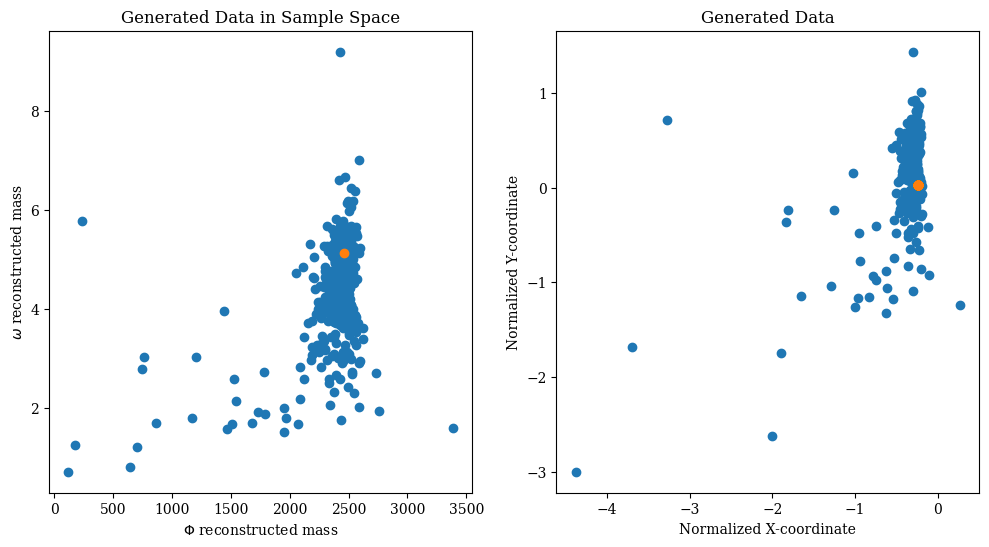

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(gen_data[:,0], gen_data[:,1])
ax2.scatter(gen_cond[:,0], gen_cond[:,1])
ax2.set_title("Generated Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

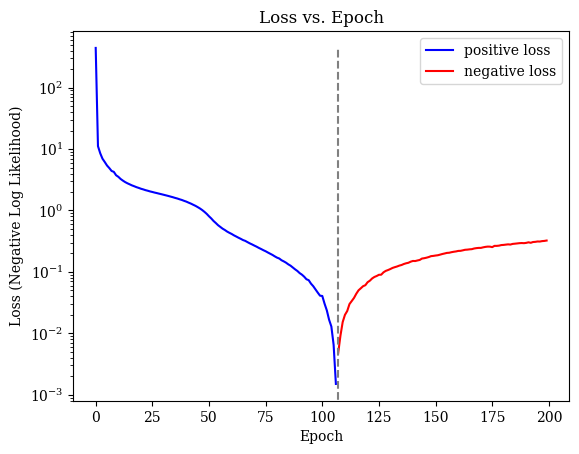

In [15]:
from fedhex.posttrain import plot as fxp
fxp.plot_losses(np.load(loss_path), show=True)